# Réseaux de neurones

*http://exo7.emath.fr/cours/livre-deepmath.pdf* 

# 0. Chargement des modules et données

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn
import tensorflow as tf

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Conv2D
from tensorflow.keras.optimizers import SGD,Adam,Nadam,Adadelta
from tensorflow import keras

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('market_data_pd.csv',sep=',')

In [3]:
df = df[df.PD_1y>0.0]
df = df[df.PD_1y!=1.0]

df.columns

Index(['Unnamed: 0', 'Reference Security', 'Bid Price', 'Ask Price',
       'Mid Price', 'Cpn', 'Maturity_x', 'Common Eqty / Tot Assets',
       'Debt/EBITDA', 'EBITDA', 'Earnings Assets / Int Bear Liab',
       'Debt / Common Equity', 'BCLASS Level 3', 'TCE Ratio',
       'Interest Coverage Ratio', 'Risk-Based Cap Ratio', 'Lev Ratio to TCE',
       'Tier-1 Ratio', 'Tot Debt / Tot Capital', 'PD_1y', 'reprice', 'Error %',
       'Issuer Name', 'Tot Cap (Local Crncy)', 'Is Covered', 'Is Convertible',
       'Guarantee Type', 'Guarantor Type', 'Collat Type', 'Amt Out',
       'OC Nominal Amt', 'Total Assets', 'Total Deposits',
       'Total Expenses to Average Earning Assets'],
      dtype='object')

In [4]:
def count_nan(df):
    for col_name in df.columns:
        n_nan = df[col_name].isna().sum()
        if n_nan > 0:
            print("Colomn : ", col_name)  
            print("NaN : {}/{}".format(n_nan,len(df[col_name])))
            print("===============================================")

In [5]:
count_nan(df)

Colomn :  Common Eqty / Tot Assets
NaN : 292/6634
Colomn :  Debt/EBITDA
NaN : 3288/6634
Colomn :  EBITDA
NaN : 2546/6634
Colomn :  Earnings Assets / Int Bear Liab
NaN : 4554/6634
Colomn :  Debt / Common Equity
NaN : 488/6634
Colomn :  TCE Ratio
NaN : 443/6634
Colomn :  Interest Coverage Ratio
NaN : 3092/6634
Colomn :  Risk-Based Cap Ratio
NaN : 4703/6634
Colomn :  Lev Ratio to TCE
NaN : 5295/6634
Colomn :  Tier-1 Ratio
NaN : 4741/6634
Colomn :  Tot Debt / Tot Capital
NaN : 339/6634
Colomn :  Tot Cap (Local Crncy)
NaN : 337/6634
Colomn :  OC Nominal Amt
NaN : 6310/6634
Colomn :  Total Assets
NaN : 413/6634
Colomn :  Total Deposits
NaN : 4729/6634
Colomn :  Total Expenses to Average Earning Assets
NaN : 6361/6634


In [6]:
#RENSEIGNER LES RATIOS FINANCIERS / VARIABLES CONSIDEREES 

#df1 = df[["Common Eqty / Tot Assets",'Debt / Common Equity','Tot Debt / Tot Capital','BCLASS Level 3',"TCE Ratio","PD_1y"]]
df1 = df[['Common Eqty / Tot Assets','TCE Ratio','Tot Debt / Tot Capital','Tot Cap (Local Crncy)','Is Covered','Is Convertible','Amt Out','BCLASS Level 3', 'Guarantee Type','Total Assets', 'Guarantor Type', 'Collat Type','Debt / Common Equity','PD_1y']]
df1 = df1[df1['Debt / Common Equity']<2500]
df1 = df1[df1['TCE Ratio']>-100]
#df1.replace(np.nan, 0.0,inplace=True)
df1.dropna(inplace=True)
count_nan(df1)

In [7]:
#df1 = df1.dropna(how = 'any') 
df1.head()

,Common Eqty / Tot Assets,TCE Ratio,Tot Debt / Tot Capital,Tot Cap (Local Crncy),Is Covered,Is Convertible,Amt Out,BCLASS Level 3,Guarantee Type,Total Assets,Guarantor Type,Collat Type,Debt / Common Equity,PD_1y
15,20.1733,20.1733,65.1743,187617.0,False,False,1.250000e+09,Technology,N.A.,323888.0,N.A.,SR UNSECURED,187.144,0.002731
16,20.1733,20.1733,65.1743,187617.0,False,False,1.250000e+09,Technology,N.A.,323888.0,N.A.,SR UNSECURED,187.144,0.002554
17,20.1733,20.1733,65.1743,187617.0,False,False,1.250000e+09,Technology,N.A.,323888.0,N.A.,SR UNSECURED,187.144,0.002540
18,20.1733,20.1733,65.1743,187617.0,False,False,1.250000e+09,Technology,N.A.,323888.0,N.A.,SR UNSECURED,187.144,0.002735
19,20.1733,20.1733,65.1743,187617.0,False,False,1.250000e+09,Technology,N.A.,323888.0,N.A.,SR UNSECURED,187.144,0.002756


In [8]:
df1.shape

(5502, 14)

# 1. Préparation des données

Nous commencerons par séparer les données non étiquietées des étiquettes, les étiquettes se trouvent dans l'array `y_full` et le reste des données dans `X_full`

In [9]:
X_full = np.array(df1.drop(columns=['PD_1y']))
y_full = np.array(df1['PD_1y'])

La prochaine étape consiste à séparer les features continues des features discrètes, cela sera utile car leurs traitements seront différent

In [10]:
features = list(df1.drop(columns=['PD_1y']).columns)

discrete_features = ['BCLASS Level 3','Guarantee Type','Guarantor Type','Collat Type','Is Covered','Is Convertible']
continuous_features = [s for s in features if not s in discrete_features]


continuous_features_idx = [features.index(feat_name) for feat_name in continuous_features]
discrete_features_idx = [features.index(feat_name) for feat_name in discrete_features]

## a. Statistiques descriptives

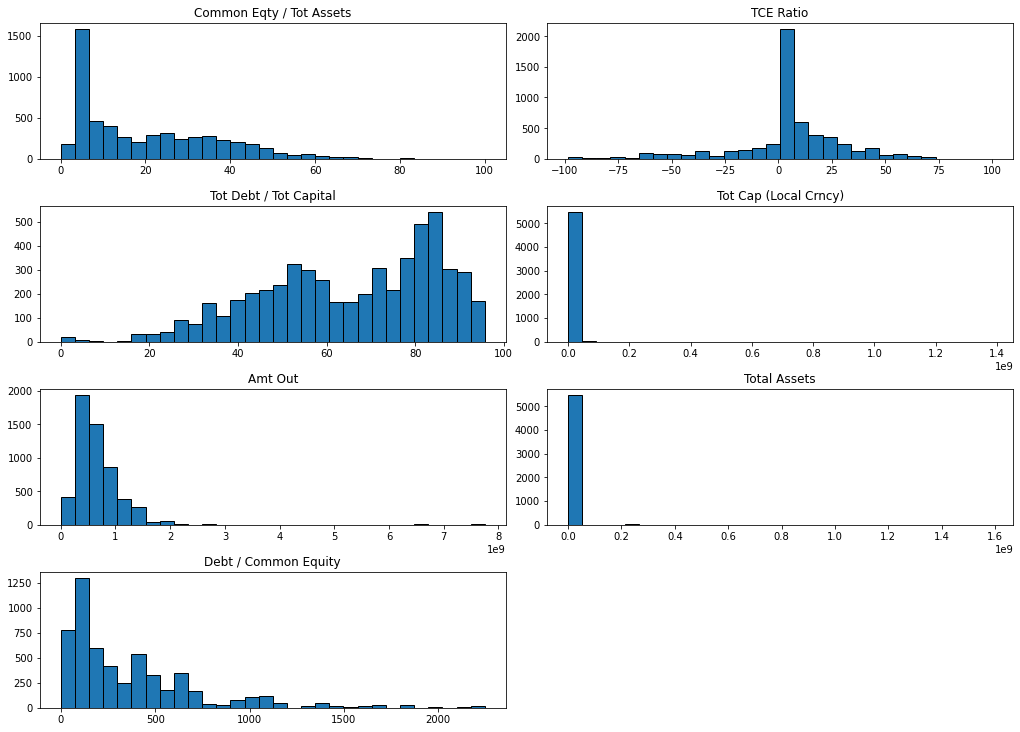

In [11]:
fig = plt.figure(figsize=(14,10))

# Histograms for continuous features
for (plot_idx, feat_idx) in enumerate(continuous_features_idx):

    # create a subplot in the (plot_idx+1) position of a 2x2 grid
    ax = fig.add_subplot(4, 2, (plot_idx+1))
    # plot the histogram of feat_idx
    h = ax.hist(X_full[:, feat_idx], bins=30, edgecolor='black')
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
# espacement entre les subplots
fig.tight_layout(pad=0.1)

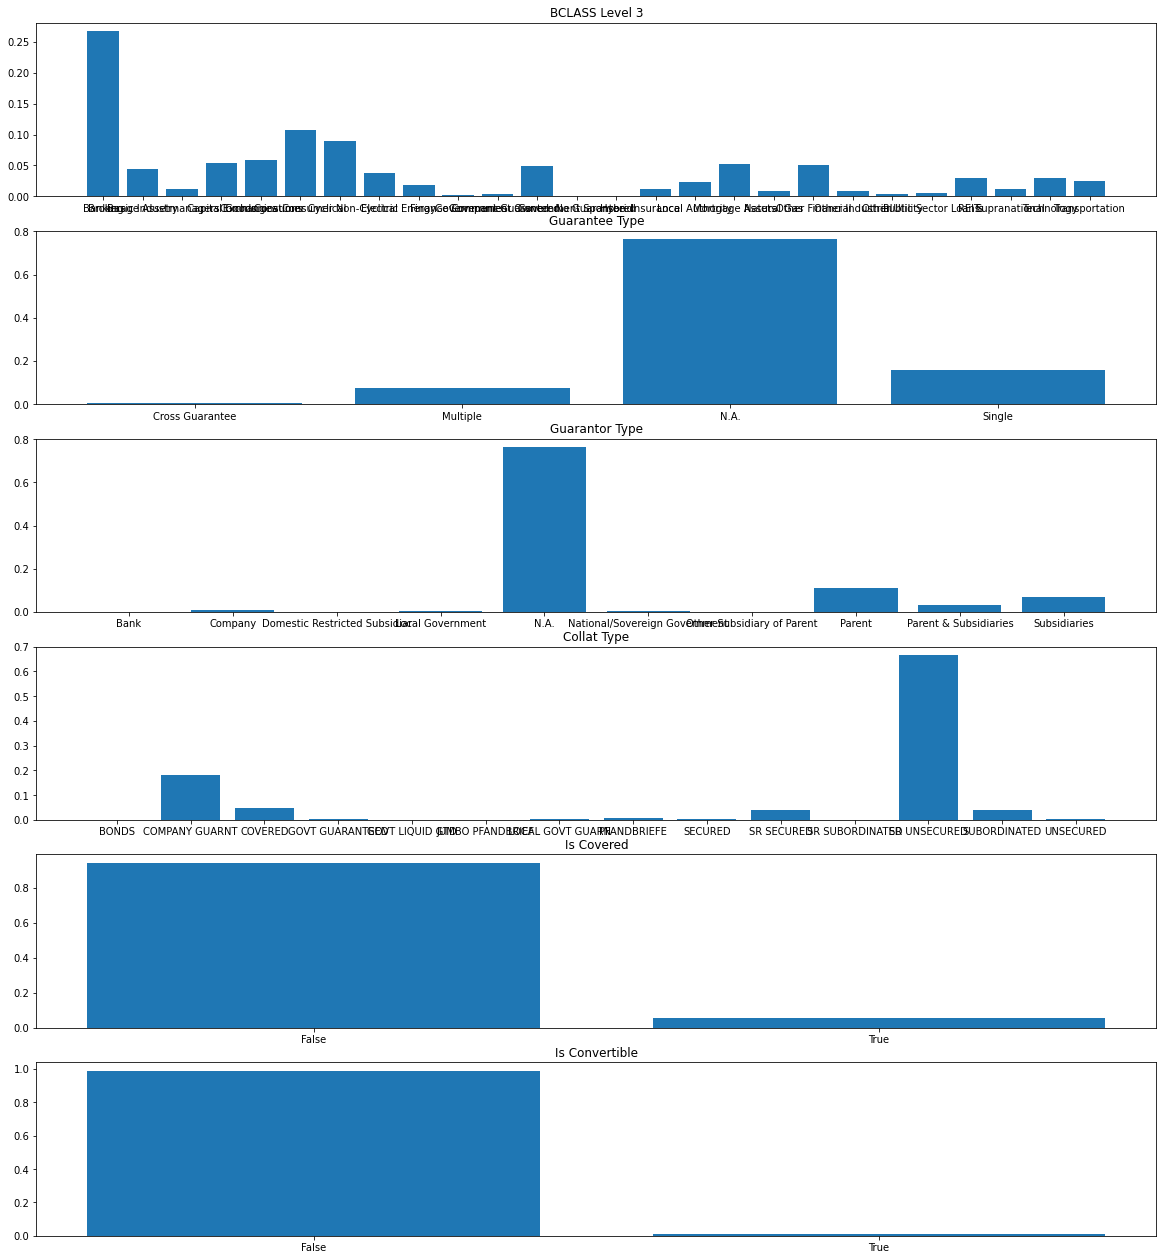

In [12]:
# Bar plots for discrete features
fig = plt.figure(figsize=(16, 20))

for (plot_idx, feat_idx) in enumerate(discrete_features_idx):
    # create a subplot in the (plot_idx+1) position of a 1x3 grid
    ax = fig.add_subplot(7, 1, (plot_idx+1))

    feature_values = np.unique(X_full[:, feat_idx])
    frequencies = [(float(len(np.where(X_full[:, feat_idx]==value)[0]))/X_full.shape[0]) \
                   for value in feature_values]
    
    b = ax.bar(range(len(feature_values)), frequencies, width=0.8, 
               tick_label=list([n for n in feature_values]))
    
    
    # use the name of the feature as a title for each histogram
    ax.set_title(features[feat_idx])
    
fig.tight_layout(pad=0.15)

## b. Traitement des données

In [13]:
## A FAIRE COMME CELA :
"""
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train_submit)

X_train_submit = enc.transform(X_train_submit)
X_test_submit = enc.transform(X_test_submit)

"""



class Pipeline:
    def __init__(self, X_train):
        """
        Se fit sur le jeu de TRAIN, une seule fois
        """
        self.ohe = preprocessing.OneHotEncoder(categories='auto',sparse=False).fit(X_train[:,discrete_features_idx])
        self.std_scaler = preprocessing.StandardScaler().fit(X_train[:,continuous_features_idx])
        print(self.ohe.categories_)
        
    def traitement(self,X):
        """
        Permet de traiter n'importe quel vecteur X ensuite
        """
    
        X_continuous_scaled = self.std_scaler.transform(X[:,continuous_features_idx])
        X_discrete_encoded = self.ohe.transform(X[:,discrete_features_idx])
        print('moyenne = {}'.format(np.mean(X_continuous_scaled)))
        
        X_processed = np.hstack((X_discrete_encoded, X_continuous_scaled))
    
        return X_processed

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_full, y_full, test_size=0.10,
                                                                    #stratify=y_full, # stratification
                                                                    random_state=92)

pipe = Pipeline(X_train)
X_train = pipe.traitement(X_train)
X_test  = pipe.traitement(X_test)

[array(['Banking', 'Basic Industry', 'Brokerage Assetmanagers Exchanges',
       'Capital Goods', 'Communications', 'Consumer Cyclical',
       'Consumer Non-Cyclical', 'Electric', 'Energy', 'Finance Companies',
       'Government Guaranteed', 'Government Owned. No Guarantee',
       'Government Sponsored', 'Hybrid', 'Insurance', 'Local Authority',
       'Mortgage Assets', 'Natural Gas', 'Other Financial',
       'Other Industrial', 'Other Utility', 'Public Sector Loans',
       'REITs', 'Supranational', 'Technology', 'Transportation'],
      dtype=object), array(['Cross Guarantee', 'Multiple', 'N.A.', 'Single'], dtype=object), array(['Bank', 'Company', 'Domestic Restricted Subsidiar',
       'Local Government', 'N.A.', 'National/Sovereign Government',
       'Other Subsidiary of Parent', 'Parent', 'Parent & Subsidiaries',
       'Subsidiaries'], dtype=object), array(['BONDS', 'COMPANY GUARNT', 'COVERED', 'GOVT GUARANTEED',
       'GOVT LIQUID GTD', 'JUMBO PFANDBRIEF', 'LOCAL GOVT GUA

## b. Traitement des données

### Première version de traitement des données (beug sur subtilité bases de train/test)

### Version corrigée (à rechercker)

Séparation en base de test / train. Besoin de distinguer les cas selon le type de variables : 

$-$ variables quali : les binariser avant de séparer en test et train afin d'avoir des colonnes pour toutes les modalités existantes dans le dataset. 

$-$ variable quanti : il faut les standariser en fonction de la base de train, càd : on entraîne la standardisation QUE sur la base de train, puis on applique les coefficients à la base de test également. Important, **sinon notre base de train dépend de la base de test**.

*Transformation des qualis*

# II. Réseaux de neurones : prédiction de la PD

## a. Implémentation du modèle

In [15]:
X_train.shape
#RESEAUX DE NEURONES 
#http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Packages_Python_for_Deep_Learning.pdf

#Explications très bien dans ce document : 

#http://exo7.emath.fr/cours/livre-deepmath.pdf 

#très bon document (parties Python, keras avec les codes et explications)

(4951, 65)

In [16]:
model = Sequential()
model.add(Dense(units=32,input_dim=65,))#activation="sigmoid")) #6 is good
model.add(Dense(units=16))
model.add(Dense(units=1,activation="sigmoid"))
#model.add(Dropout(0.2))
learning_rate = 0.0002

sgd = SGD(learning_rate)  #lr = 0.02
adam = Adam(learning_rate) #lr = 0.001

#nadam = Nadam(lr=0.0005, beta_1=0.9, beta_2=0.999)

#dim première couche = nombre de variables du df 

**Fonction sigmoïde :** continue et à valeurs dans [0,1] (comme les probabilités de défaut). Régression logit. 

In [17]:
#modele.compile(loss='mean_squared_error',optimizer=sgd,metrics=[tf.keras.metrics.MeanSquaredError()])
#optimizer = sgd
#model.compile(loss='mean_squared_error',optimizer='adam',metrics=[tf.keras.metrics.MeanSquaredError()])
#model.compile(loss=tf.keras.losses.Huber(delta=.05),optimizer=sgd,metrics=[tf.keras.metrics.MeanSquaredError()])
model.compile(loss='mean_absolute_error',optimizer=adam,metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 2,657
Trainable params: 2,657
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/10
80/80 [==============================] - 0s 2ms/step - loss: 0.4284 - mean_absolute_error: 0.4284 - val_loss: 0.2754 - val_mean_absolute_error: 0.2754
Epoch 2/10
80/80 [==============================] - 0s 862us/step - loss: 0.1646 - mean_absolute_error: 0.1646 - val_loss: 0.0847 - val_mean_absolute_error: 0.0847
Epoch 3/10
80/80 [==============================] - 0s 984us/step - loss: 0.0518 - mean_absolute_error: 0.0518 - val_loss: 0.0329 - val_mean_absolute_error: 0.0329
Epoch 4/10
80/80 [==============================] - 0s 1ms/step - loss: 0.0246 - mean_absolute_error: 0.0246 - val_loss: 0.0188 - val_mean_absolute_error: 0.0188
Epoch 5/10
80/80 [==============================] - 0s 887us/step - loss: 0.0161 - mean_absolute_error: 0.0161 - val_loss: 0.0144 - val_mean_absolute_error: 0.0144
Epoch 6/10
80/80 [==============================] - 0s 896us/step - loss: 0.0136 - mean_absolute_error: 0.0136 - val_loss: 0.0129 - val_mean_absolute_error: 0.0129
Epoch 7/10
80/80 [==

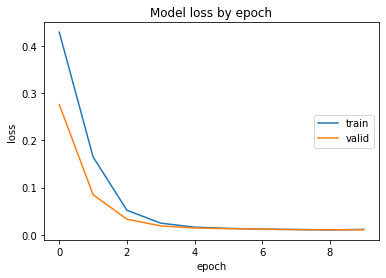

In [19]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
#callback = None
history = model.fit(np.squeeze(X_train), y_train,         # Train the model using the training set...
          batch_size=20, epochs=10,
          verbose=1, validation_split=0.2,steps_per_epoch=80,callbacks=[callback])           # ...holding out 40% of the data for validation

# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

    
import matplotlib.pyplot as plt

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [20]:
#Résultats 

resultat = model.evaluate(X_test, y_test, verbose=1)
print("Valeur de l'erreur sur les données de test (loss):", resultat[0])
print('Précision sur les données de test (MAE):', resultat[1])

18/18 [==============================] - 0s 512us/step - loss: 0.0119 - mean_absolute_error: 0.0119
Valeur de l'erreur sur les données de test (loss): 0.011914966627955437
Précision sur les données de test (MAE): 0.011914966627955437


In [55]:
#LASSO

from sklearn import linear_model
#clf = linear_model.Lasso(alpha=0.1)

clf = linear_model.ElasticNet(random_state=3)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

-0.0017695216469926223

In [107]:
#KNN

from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.8975261567971626

In [113]:
#GAUSS

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0)
gpr.fit(X_train, y_train)
gpr.score(X_test, y_test)

0.31945346347849357

In [156]:
#SVR
from sklearn.svm import SVR
regr = SVR(C=.4, epsilon=0.01)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.48852156141990644

In [157]:
#SVR

"""
def ppp(eps):
    regr = SVR(C=.4, epsilon=0.01)
    regr.fit(X_train, y_train)
    score = regr.score(X_test, y_test)
    return score
    

x_ = np.linspace(1e-3,9e-1,1000)

scores = np.vectorize(ppp)(x_)

print("best epsilon = {}".format(x_[list(scores).index(np.max(scores))]))


"""


KeyboardInterrupt: 

## b. Observation des résultats 

In [158]:
def ecart_relatif(row) : 
    théo = row['Théorique']
    préd = row['Prédiction']
    return abs(théo - préd) / théo

In [159]:
def ViewResults(model, X_test, y_test):
    prediction = pd.DataFrame(data= model.predict(X_test) ,columns=['Prédiction'])
    théorique = pd.DataFrame(data= y_test ,columns=['Théorique'])
    prediction, théorique = prediction.reset_index() , théorique.reset_index()

    results = pd.merge(théorique, prediction, on = 'index').drop(columns=['index'])
    results["Ecart_relatif"] = results.apply(ecart_relatif,axis=1)
    
    results.sort_values('Ecart_relatif',inplace=True)
    
    #print(results.tail(20))
    
    print("\n\nL'écart relatif moyen est de " + str(results["Ecart_relatif"].mean() * 100) + "%")
    
    results.plot.scatter("Théorique","Prédiction")
    plt.xlim(-.01,.1)
    plt.ylim(-.01,.1)

Resultat pour la regression SVR


L'écart relatif moyen est de 121.9330089336059%


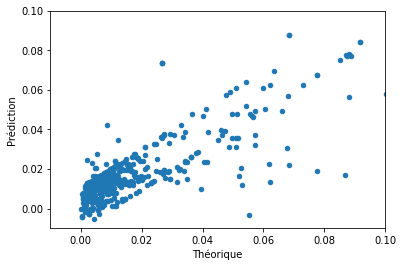

In [160]:
print('Resultat pour la regression SVR')
ViewResults(regr, X_test, y_test)

Resultat pour la regression 1-NN


L'écart relatif moyen est de 15.963814106147561%


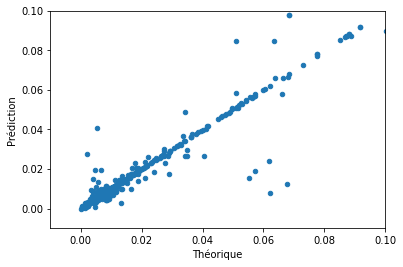

In [161]:
print('Resultat pour la regression 1-NN')
ViewResults(neigh,X_test,y_test)

Resultat pour la regression via Dense Neural Net


L'écart relatif moyen est de 158.54630953639634%


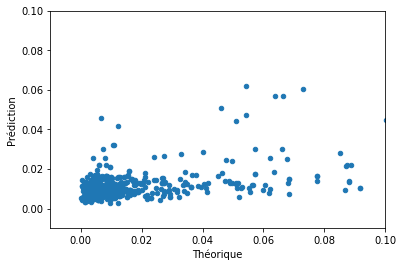

In [162]:
print('Resultat pour la regression via Dense Neural Net')
ViewResults(model,X_test,y_test)

---------------

# III. Réseaux de neurones : Test classification multi-classe

In [ ]:
df = pd.read_csv('market_data_pd.csv',sep=',')
#df = df[["Common Eqty / Tot Assets",'Debt / Common Equity','BCLASS Level 3',"PD_1y","TCE Ratio"]]

df = df[['Common Eqty / Tot Assets','TCE Ratio','Tot Debt / Tot Capital','Tot Cap (Local Crncy)','Is Covered','Is Convertible','Amt Out','BCLASS Level 3', 'Guarantee Type', 'Guarantor Type', 'Collat Type','Debt / Common Equity','PD_1y']]


#['BCLASS Level 3','Guarantee Type','Guarantor Type','Collat Type','Is Covered','Is Convertible']]

df = df[df.PD_1y>0.0]
df = df[df.PD_1y!=1.0]
df = df[df.PD_1y<0.05]
df = df[df['Debt / Common Equity']<2e4]
df = df[df['TCE Ratio']>-100]

#df['PD_1y'] = pd.read_csv('PD_1y.csv')['PD_1y']
#df.replace(np.nan, 0.0,inplace=True)
df.dropna(inplace=True)

## a. Classification des PD

**Première version de traitement des données (beug sur subtilité bases de train/test)**

In [ ]:
#ATTENTION : CHANGEMENT A FAIRE 
#il faut paramétrer les algorithmes de classification seulement en utilisant la base de train. 
#et ensuite seulement, appliquer la classification sur la base de test 

#sinon, tu utilises une base normalement inconnue (la base de test) pour paramétrer ton algo. 
#(même si le changement est pas ouf, il faut inverser l'ordre dans lequel on fait ça)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_full, y_full, test_size=0.10,
                                                                    #stratify=y_full, # stratification
                                                                    random_state=92)
pipe = Pipeline(X_train)
X_train = pipe.traitement(X_train)
X_test  = pipe.traitement(X_test)

In [ ]:
#X_train = X_train[:, np.newaxis] # Reshape in "convolutionable" format (add tensor dim for the depth)
#X_test = X_test[:, np.newaxis]

In [ ]:
X_train.shape

**Version corrigée (à rechercker)**

In [ ]:
#Au départ : reprendre base de train et de test créées dans la partie I. 
#X_train, y_train, X_test, y_test

class Discretizer:
    def __init__(self, y_train, nb_class=6):
        
        self.nb_class = nb_class
        self.y_train = y_train.reshape((-1,1))

        self.kbins = KBinsDiscretizer(n_bins=self.nb_class, encode='ordinal', strategy='quantile')#strategy : uniform, quantile, kmeans
        self.kbins.fit(self.y_train)
        
        
    def discretize(self,y):
        y = y.reshape((-1,1))
        y_class = self.kbins.transform(y)
        return y_class

In [ ]:
nb_class = 7
discretizer = Discretizer(y_train, nb_class=nb_class)

y_train_class = discretizer.discretize(y_train)
y_test_class  = discretizer.discretize(y_test)

In [ ]:
plt.hist(y_train_class, range = (0, nb_class), bins = nb_class, edgecolor='black' )
plt.xlabel('Classes')
plt.ylabel('Nombre de bonds')
plt.title('Histogramme du nombre de bonds par classe - base de train')
plt.show()

In [ ]:
plt.hist(y_test_class, range = (0, nb_class), bins = nb_class, edgecolor='black' )
plt.xlabel('Classes')
plt.ylabel('Nombre de bonds')
plt.title('Histogramme du nombre de bonds par classe - base de test')
plt.show()

## b. Implémentation du modèle

In [ ]:
"""
input_shape = (20, 1, 34)

num_classes=6

from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist # subroutines for fetching the MNIST dataset
from tensorflow.keras.models import Model, Sequential # basic class for specifying and training a neural network
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten 
# --------------------------------------
# Network params
# --------------------------------------
# Network params
batch_size = 32    # in each iteration, we consider 32 training examples at once
num_epochs = 15    # we iterate 15 times over the entire training set
kernel_size = 5    # we will use 5x5 kernels throughout
pool_size = 2      # we will use 2x2 pooling throughout
conv_depth_1 = 6   # we will initially have 6 kernels in first conv. layer...
conv_depth_2 = 16  # ...switching to 16 after the first pooling layer
drop_prob_1 = 0.   # dropout after pooling with probability 0.
drop_prob_2 = 0.   # dropout in the FC layer with probability 0.
hidden_size = 128  # the FC layer will have 128neurons
weight_penalty = 0. # Factor for weights penalty

# --------------------------------------
# CNN network definition 
# --------------------------------------
# inp = Input(shape=(1,height,width)) # greyscale --> depth==1
# model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

model = Sequential()
# Conv [8] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), padding='same', activation='relu', data_format="channels_last", input_shape=(20,1,34)) )
#model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
#model.add( Dropout(drop_prob_1) )

# Conv [16] -> Pool (with dropout on the pooling layer)
#model.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), padding='same', activation='relu') )
#model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
#model.add( Dropout(drop_prob_1) )

# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
model.add( Flatten() )
#model.add( Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)) )
#model.add( Dropout(drop_prob_2) )
model.add( Dense(num_classes, activation='softmax') )

print(model.summary())

"""
from tensorflow.keras.layers import LSTM
model = Sequential()
#model.add(Conv1D(12, 2, activation='relu',input_shape=input_shape[1:]))
model.add(Dense(units=32,input_dim=65)) #6 is good

model.add(Dropout(0.4))
model.add(Dense(units=nb_class,activation="softmax")) #output


#32, 3, activation='relu', input_shape=input_shape[2:])(x)




In [ ]:
from tensorflow import keras 

model.compile(optimizer=keras.optimizers.Adam(lr=0.0003),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
#model.fit(X_train,y_train,validation_split=0.4, epochs=40)

In [ ]:




history = model.fit(X_train, y_train_class,         # Train the model using the training set...
          batch_size=20, epochs=100,
          verbose=1, validation_split=0.1,steps_per_epoch=250)  

In [ ]:
#OvsRest
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

#poly & degree=11

clf = OneVsRestClassifier(SVC(kernel='poly',degree=11),n_jobs=-1).fit(X_train, y_train_class)
resultat = clf.predict(X_test)

print(clf.score(X_test,y_test_class))

In [ ]:
#one vs one


from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

degree = [i for i in range(2,100)]

def pipe(deg):
    clf= OneVsOneClassifier(SVC(kernel='poly',degree=deg),n_jobs=-1).fit(X_train, np.ravel(y_train_class))
    clf.predict(X_test)
    return clf.score(X_test,np.ravel(y_test_class))

scores = [pipe(deg) for deg in degree]

scores = np.vectorize(pipe)(np.array(degree))

print(degree[scores.index(np.max(scores))])

#print(clf.score(X_test,np.ravel(y_test_class)))

In [ ]:
# Random forest:

from sklearn.multiclass import OutputCodeClassifier
from sklearn.ensemble import RandomForestClassifier


    
clf = OutputCodeClassifier(
    estimator=RandomForestClassifier(n_estimators=800,
                                     criterion='gini', #{“gini”, “entropy”}
                                     max_depth=100, #default=None
                                     min_samples_split=2, #int or float, default=2
                                     random_state=42,
                                     max_features='auto',
                                     bootstrap=True,
                                     min_samples_leaf=1
                                    ),
    random_state=42,n_jobs=-1)

clf.fit(X_train, np.ravel(y_train_class))

resultat = clf.predict(X_test)

print(clf.score(X_test,y_test_class))
"""
{'estimator__n_estimators': 800, 
 'estimator__min_samples_split': 2, 
 'estimator__min_samples_leaf': 1, 
 'estimator__max_features': 'auto', 
 'estimator__max_depth': 100, 
 'estimator__bootstrap': True}
"""



In [ ]:
print("best n_estimators = {}".format(estim[list(scores).index(np.max(scores))]))

In [ ]:
clf.get_params()

In [ ]:
#RF FINE TUNING

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__bootstrap': bootstrap}


In [ ]:

rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train_class)

In [ ]:
print(rf_random.best_params_)

In [ ]:
# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, y_test_class, verbose=1))):
    print('The final {} on the TEST set is: {:.2f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

In [ ]:
y=model.predict(np.squeeze(X_test))

In [ ]:
y_predicted = [np.argmax(pred) for pred in y]

y_predicted = resultat

In [ ]:
for i in range(len(y_predicted)):
    print("predicted: ", y_predicted[i], "| Actual Label: ",y_test_class[i][0], " True" if (y_predicted[i]==y_test_class[i][0]) else " False")
print("\n")
print(np.sum(y_predicted==y_test_class[:,0]),'/',len(y_predicted))

In [ ]:
CM = confusion_matrix(y_test_class[:,0], y_predicted)

In [ ]:
ConfusionMatrixDisplay(CM).plot()